In [1]:
import numpy as np
import pandas as pd
import nltk
import string
import re

#from wordcloud import WordCloud
import matplotlib.pyplot as plt
from string import punctuation
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud


In [182]:
!pip install wordcloud

In [2]:
true0 = pd.DataFrame(pd.read_csv('./true.csv'))
fake0 = pd.DataFrame(pd.read_csv('./fake.csv'))

In [3]:
true0.subject.value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

In [4]:
fake0.subject.value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [5]:
fake_politics = fake0[fake0.subject.isin(['Government News', 'politics'])]
true_politics = true0[true0.subject == 'politicsNews']

In [6]:
# Filter the news of 2016
fake_politics_2016 = fake_politics[fake_politics['date'].str.contains('2016')]
true_politics_2016 = true_politics[true_politics['date'].str.contains('2016')]

In [7]:
fake1 = fake_politics_2016
true1 = true_politics_2016

In [8]:
fake1['label']='Fake'
true1['label']='True'

C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
news=fake1.append(true1)

In [10]:
news.head()

,title,text,subject,date,label
12023,TRUMP DITCHES PRESS To Make “Last Minute” Surp...,President-elect Donald Trump played a round of...,politics,"Dec 31, 2016",Fake
12024,"COUNTDOWN TICKER: Obama Leaves Office In…5,4,3...",(function(){ var s=document.createElement('scr...,politics,"Dec 31, 2016",Fake
12025,BOOM! TOMI LAHREN’S Top Tips For Liberals In 2...,,politics,"Dec 31, 2016",Fake
12026,"YES, OBAMA…There Is A Magic Wand! [Video]",,politics,"Dec 31, 2016",Fake
12027,HA! DONALD TRUMP’S Unusual New Year’s Tweet To...,President-elect Donald Trump is throwing a pri...,politics,"Dec 31, 2016",Fake


In [11]:
#data cleaning

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)


In [12]:
def strip_html(text):
    soup = BeautifulSoup(text,"html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_url(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip().lower())
    return " ".join(final_text)

#Removing punctuation
def remove_punctuation(text):
    pattern = '[’!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+'
    text = re.sub(pattern,'',text)
    return text

#Since 'reuters' is shown in almost every piece of true news, we want to remove it from the true news
def remove_reuters(text):
    if 'reuters' in text.split()[0:5]:
        text = text[text.find('reuters'):]
        text = text.split(' ', 1)[1]
    return text
    

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_url(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    text = remove_reuters(text)
    text.lower()
  
    return text


In [13]:
#Apply function on text and title column
news['text']=news['text'].apply(denoise_text)
news['title']=news['title'].apply(denoise_text)

C:\Users\Administrator\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "https://www.youtube.com/watch?v=IioEIUmawRo" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\Administrator\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "https://www.youtube.com/watch?v=31MRqr9ydUU" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\Administrator\Anaconda3\lib\site-packages\bs4\__init__.py:336: UserWarning: "https://www.youtube.com/watch?v=wYdX071Nlow" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the doc

In [14]:
# drop those empty text data 
news = news[news.text != '']

In [15]:
news.sample(n=8)

,title,text,subject,date,label
7040,trump considers retired general petraeus top d...,donald trump meet retired us general david pet...,politicsNews,"November 28, 2016",True
9861,apple refused china request source code last t...,apple inc aaplo asked chinese authorities with...,politicsNews,"April 19, 2016",True
12877,un news agency scrubs tweet calling americans ...,united nations news centre official un news se...,politics,"Sep 30, 2016",Fake
11145,atlantic city nj hold emergency meeting discus...,atlantic city mayor guardian thursday called e...,politicsNews,"January 21, 2016",True
13907,police called grisly murder scene find decapit...,better blowup doll actual citizen city l beck ...,politics,"May 13, 2016",Fake
10132,us top court hands win unions splits 44 withou...,public sector unions triumphed us supreme cour...,politicsNews,"March 29, 2016",True
12630,list 65 mainstream media “journalists” never t...,many hacks list like rachel maddow mark halper...,politics,"Oct 24, 2016",Fake
8453,former fox news chief ailes advising trump cam...,roger ailes fox news chairman ousted last mont...,politicsNews,"August 16, 2016",True


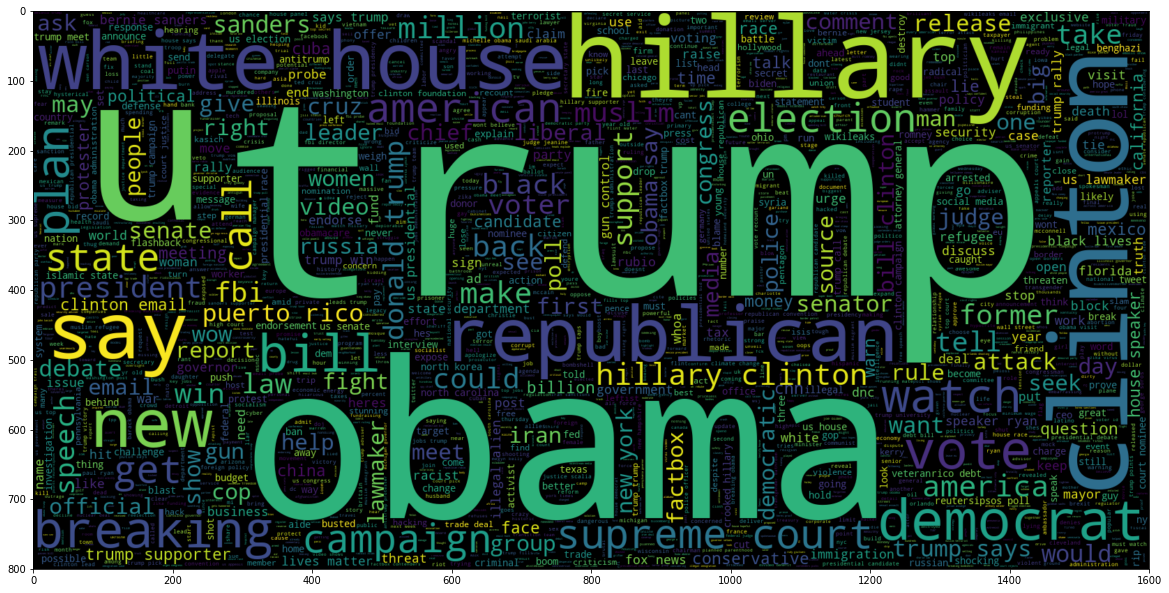

In [16]:
#wordcloud all news based on the titles
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop).generate(" ".join(news.title))
plt.imshow(wc , interpolation = 'bilinear')

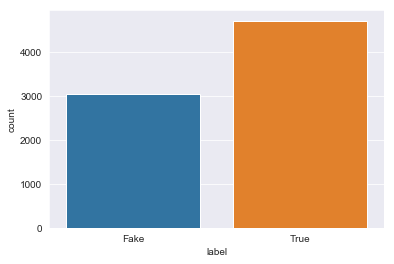

In [17]:
sns.set_style("darkgrid")
sns.countplot(news.label)

In [18]:
# select the title and text data
X = news[['title', 'text']]

In [19]:
# The outcome is always label
Y = news[['label']]

In [20]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=42,shuffle=True)

In [21]:
# Split the data as two sources: title and text 
x_train_title = x_train['title']
x_train_text = x_train['text']
x_test_title = x_test['title']
x_test_text = x_test['text']

In [22]:
y_train = y_train['label']
y_test = y_test['label']

# 1. Prediction based on Title

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score

In [24]:
# Model 1: Naive Bayes Model with TF-IDF inputs
model1_title = make_pipeline(TfidfVectorizer(), MultinomialNB())
model1_title.fit(x_train_title, y_train)
pred1_title = model1_title.predict(x_test_title)
f1_macro = f1_score(y_test, pred1_title, average = 'macro')
f1_micro = f1_score(y_test, pred1_title, average = 'micro')

print('macroaveraged F1: ', f1_macro)
print('microaveraged F1: ', f1_micro)

macroaveraged F1:  0.9164237914797764
microaveraged F1:  0.9207474226804123


Text(28.6, 0.5, 'predicted label')

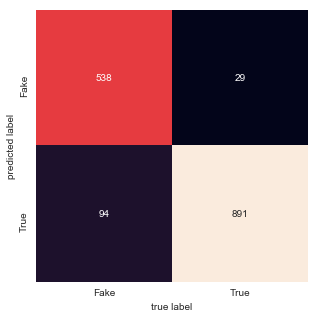

In [358]:
# plot the confusion matrix
mat = confusion_matrix(y_test, pred1_title)
labels = ['Fake', 'True']
plt.figure(figsize=(5,5))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=label_name, yticklabels=label_name)
plt.xlabel('true label')
plt.ylabel('predicted label')


In [204]:
from sklearn.neural_network import MLPClassifier

In [178]:
# Model 2: Single Layer Neural Network Model with TF-IDF inputs
model2_title = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(50, ), random_state=1, verbose = True))
model2_title.fit(x_train_title, y_train)
pred2_title = model2_title.predict(x_test_title)
f1_macro = f1_score(y_test, pred2_title, average = 'macro')
f1_micro = f1_score(y_test, pred2_title, average = 'micro')

print('macroaveraged F1: ', f1_macro)
print('microaveraged F1: ', f1_micro)

Iteration 1, loss = 0.57872058
Iteration 2, loss = 0.14476254
Iteration 3, loss = 0.01443936
Iteration 4, loss = 0.00206390
Iteration 5, loss = 0.00042157
Iteration 6, loss = 0.00029928
Iteration 7, loss = 0.00026620
Iteration 8, loss = 0.00025044
Iteration 9, loss = 0.00024038
Iteration 10, loss = 0.00023209
Iteration 11, loss = 0.00022225
Iteration 12, loss = 0.00021512
Iteration 13, loss = 0.00021154
Iteration 14, loss = 0.00020941
Iteration 15, loss = 0.00020780
Iteration 16, loss = 0.00020639
Iteration 17, loss = 0.00020510
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [184]:
# Model 3: Multi Layer Neural Network Model with TF-IDF inputs
model3_title = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(200,200,200,200, ),random_state=1, verbose = True))
model3_title.fit(x_train_title, y_train)
pred3_title = model3_title.predict(x_test_title)
f1_macro = f1_score(y_test, pred3_title, average = 'macro')
f1_micro = f1_score(y_test, pred3_title, average = 'micro')

print('macroaveraged F1: ', f1_macro)
print('microaveraged F1: ', f1_micro)

Iteration 1, loss = 0.72492505
Iteration 2, loss = 0.61640651
Iteration 3, loss = 0.48880232
Iteration 4, loss = 0.36929838
Iteration 5, loss = 0.27588472
Iteration 6, loss = 0.20904614
Iteration 7, loss = 0.16243347
Iteration 8, loss = 0.12940727
Iteration 9, loss = 0.10540507
Iteration 10, loss = 0.08744336
Iteration 11, loss = 0.07353728
Iteration 12, loss = 0.06260078
Iteration 13, loss = 0.05394385
Iteration 14, loss = 0.04679443
Iteration 15, loss = 0.04108177
Iteration 16, loss = 0.03623122
Iteration 17, loss = 0.03221671
Iteration 18, loss = 0.02875323
Iteration 19, loss = 0.02589628
Iteration 20, loss = 0.02342234
Iteration 21, loss = 0.02123888
Iteration 22, loss = 0.01936575
Iteration 23, loss = 0.01775930
Iteration 24, loss = 0.01632999
Iteration 25, loss = 0.01508094
Iteration 26, loss = 0.01397238
Iteration 27, loss = 0.01296217
Iteration 28, loss = 0.01209215
Iteration 29, loss = 0.01130194
Iteration 30, loss = 0.01058671
Iteration 31, loss = 0.00993870
Iteration 32, los

0.9304210625966403

In [ ]:
# Model 4: Single Layer Neural Network Model with embedding inputs

In [ ]:
# Model 5: Multi Layer Neural Network Model with embedding inputs

# 2. Prediction based on Text

In [359]:
# Model 1: Naive Bayes Model with TF-IDF inputs
model1_text = make_pipeline(TfidfVectorizer(), MultinomialNB())
model1_text.fit(x_train_text, y_train)
pred1_text = model1_text.predict(x_test_text)
f1_macro = f1_score(y_test, pred1_text, average = 'macro')
f1_micro = f1_score(y_test, pred1_text, average = 'micro')

print('macroaveraged F1: ', f1_macro)
print('microaveraged F1: ', f1_micro)

macroaveraged F1:  0.6561258928365161
microaveraged F1:  0.7280927835051546


In [361]:
# Model 2: Single Layer Neural Network Model with TF-IDF inputs
model2_text = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(50, ), random_state=1, verbose = True))
model2_text.fit(x_train_text, y_train)
pred2_text = model2_text.predict(x_test_text)
f1_macro = f1_score(y_test, pred2_text, average = 'macro')
f1_micro = f1_score(y_test, pred2_text, average = 'micro')

print('macroaveraged F1: ', f1_macro)
print('microaveraged F1: ', f1_micro)

Iteration 1, loss = 0.58245266
Iteration 2, loss = 0.38159907
Iteration 3, loss = 0.24361029
Iteration 4, loss = 0.15631934
Iteration 5, loss = 0.10512789
Iteration 6, loss = 0.07404984
Iteration 7, loss = 0.05428268
Iteration 8, loss = 0.04118252
Iteration 9, loss = 0.03232138
Iteration 10, loss = 0.02598328
Iteration 11, loss = 0.02135815
Iteration 12, loss = 0.01792994
Iteration 13, loss = 0.01531616
Iteration 14, loss = 0.01326387
Iteration 15, loss = 0.01166071
Iteration 16, loss = 0.01035442
Iteration 17, loss = 0.00928919
Iteration 18, loss = 0.00839350
Iteration 19, loss = 0.00764524
Iteration 20, loss = 0.00701869
Iteration 21, loss = 0.00649077
Iteration 22, loss = 0.00603846
Iteration 23, loss = 0.00564599
Iteration 24, loss = 0.00530277
Iteration 25, loss = 0.00499987
Iteration 26, loss = 0.00473181
Iteration 27, loss = 0.00449091
Iteration 28, loss = 0.00427638
Iteration 29, loss = 0.00408811
Iteration 30, loss = 0.00391097
Iteration 31, loss = 0.00375560
Iteration 32, los

In [ ]:
# Model 3: Single Layer Neural Network Model with TF-IDF inputs
model3_text = make_pipeline(TfidfVectorizer(), MLPClassifier(hidden_layer_sizes=(100,100,100, ), random_state=1, verbose = True))
model3_text.fit(x_train_text, y_train)
pred3_text = model3_text.predict(x_test_text)
f1_macro = f1_score(y_test, pred3_text, average = 'macro')
f1_micro = f1_score(y_test, pred3_text, average = 'micro')

print('macroaveraged F1: ', f1_macro)
print('microaveraged F1: ', f1_micro)